# Inference on the trained checkpoint

In this notebook we will visualize the results of the training and compute some metrics of importance from a scientific analysis standpoint to further evaluate the performance of the model. This notebook can be executed after the training for the model is complete.

Let's jump right in. We will start with reading the validation dataset



In [1]:
import glob
import torch
import numpy as np

path = "./datasets/jhtdb_valid"
files = glob.glob(path + "/*_1_1_1_filter_width_1.npy")

batch_size = 4

low_res = []
high_res = []
for file in files:
    data_high_res = np.load(file)
    data_low_res = np.load(file[:-25] + "_4_4_4_filter_width_4.npy")
    low_res.append(np.rollaxis(data_low_res, -1, 0))
    high_res.append(np.rollaxis(data_high_res, -1, 0))

U_lr_true = torch.from_numpy(np.stack(low_res, axis=0)).to(torch.float).to("cuda")
U_hr_true = torch.from_numpy(np.stack(high_res, axis=0)).to(torch.float).to("cuda")

## Generate Model inference

Here, we will instantiate the model in the same form as done in the training and load the trained checkpoint. We will then execute the model in inference mode on the low resolution input data to generate the model prediction

In [2]:
import torch

from physicsnemo.sym.key import Key
from physicsnemo.sym.hydra.utils import compose
from physicsnemo.sym.hydra import instantiate_arch

cfg = compose(config_path="conf", config_name="config")

model = instantiate_arch(
    input_keys=[Key("U_lr", size=3)],
    output_keys=[Key("U", size=3)],
    cfg=cfg.arch.super_res,
)
model.make_node(name="super_res")
model.load("./outputs/super_resolution/")

model.eval().cuda()

with torch.inference_mode():
    output_tensor = model({"U_lr": U_lr_true})

U_hr_pred = output_tensor["U"]

/raid/kaustubh_backup/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/raid/kaustubh_backup/anaconda3/lib/python3.10/site-packages/physicsnemo/sym/hydra/utils.py:150: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(
TorchScript default is being turned off due to PyTorch version mismatch.
2024-07-02 19:01:03.837477: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 19:01:04.768565: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find T

## Pre-process the data

Here we will pre-process the data and compute some of the metrics that are important for analysis of turbulent flows. We will also generate an interpolated dataset to compare how the neural network result compares with the simple interpolation methods 

In [3]:
from inference_utils import compute_velocity_grad, compute_p_q_r

zoom_factors = (1, 1, 128 / 32, 128 / 32, 128 / 32)
zoom_factors_torch = (128 / 32, 128 / 32, 128 / 32)
# bicubic from scipy is too slow and torch only supports 4D tensors interpolatioin.
# U_hr_interp = torch.from_numpy(zoom(data_low_res["U_lr"], zoom_factors, order=3)).to("cuda")    # bicubic
U_hr_interp = torch.nn.functional.interpolate(
    U_lr_true, scale_factor=zoom_factors_torch, mode="trilinear"
)

# Compute the velocity gradients

U_lr_true_grad = compute_velocity_grad(U_lr_true)
U_hr_interp_grad = compute_velocity_grad(U_hr_interp)
U_hr_true_grad = compute_velocity_grad(U_hr_true)
U_hr_pred_grad = compute_velocity_grad(U_hr_pred)

p_lr_true, q_lr_true, r_lr_true = compute_p_q_r(U_lr_true_grad)
p_hr_interp, q_hr_interp, r_hr_interp = compute_p_q_r(U_hr_interp_grad)
p_hr_true, q_hr_true, r_hr_true = compute_p_q_r(U_hr_true_grad)
p_hr_pred, q_hr_pred, r_hr_pred = compute_p_q_r(U_hr_pred_grad)

## Plot the raw fields

Let's start by visualizing the raw fields. We will use matplotlib to visualize a slice of the data. 


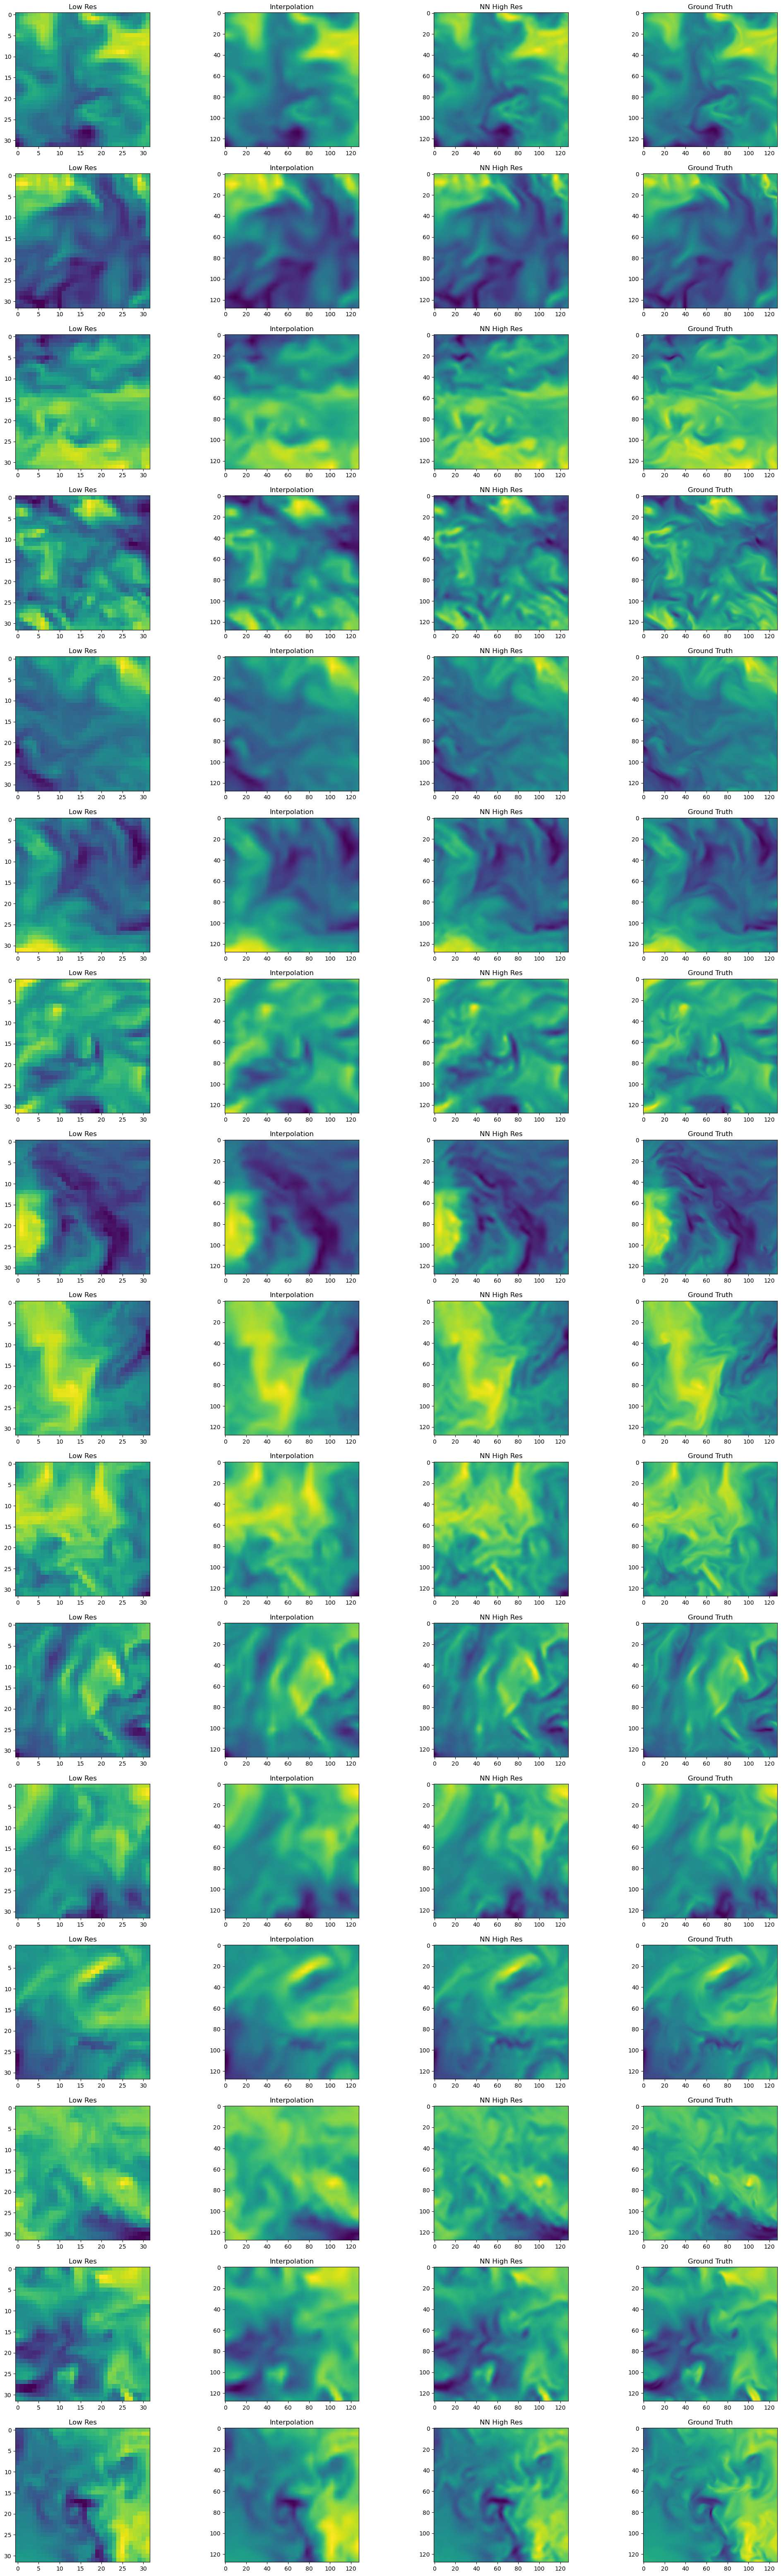

In [4]:
import matplotlib.pyplot as plt

# Plot mid z slice of u component for the first element in the batch
fig, axs = plt.subplots(U_lr_true.shape[0], 4, figsize=(5 * 5, 5 * U_lr_true.shape[0]))

for i in range(U_lr_true.shape[0]):
    axs[i, 0].imshow(U_lr_true.cpu().numpy()[i, 0, ..., 16])
    axs[i, 0].set_title("Low Res")
    axs[i, 1].imshow(U_hr_interp.cpu().numpy()[i, 0, ..., 64])
    axs[i, 1].set_title("Interpolation")
    axs[i, 2].imshow(U_hr_pred.cpu().numpy()[i, 0, ..., 64])
    axs[i, 2].set_title("NN High Res")
    axs[i, 3].imshow(U_hr_true.cpu().numpy()[i, 0, ..., 64])
    axs[i, 3].set_title("Ground Truth")
plt.show()

From the slice plots it can be observed that the Neural Network result performs better than the trilinear interpolation and matches better with the Ground truth. However the finer details are still missing from the NN prediction. In the subsequent steps, we will do some more detailed analysis of the fields. 

## Plot the Q-R diagrams

Q-R diagrams form an important analysis of the turbulent flows. Q and R are the second and third invariants of the velocity gradient tensor. The first invariant typically denoted by P is zero for the incompressible turbulent flows. 

/tmp/ipykernel_2098578/2743031798.py:98: UserWarning: Log scale: values of z <= 0 have been masked
  da = axs[0].contourf(
/tmp/ipykernel_2098578/2743031798.py:128: UserWarning: Log scale: values of z <= 0 have been masked
  da = axs[1].contourf(
/tmp/ipykernel_2098578/2743031798.py:158: UserWarning: Log scale: values of z <= 0 have been masked
  da = axs[2].contourf(
/tmp/ipykernel_2098578/2743031798.py:188: UserWarning: Log scale: values of z <= 0 have been masked
  da = axs[3].contourf(


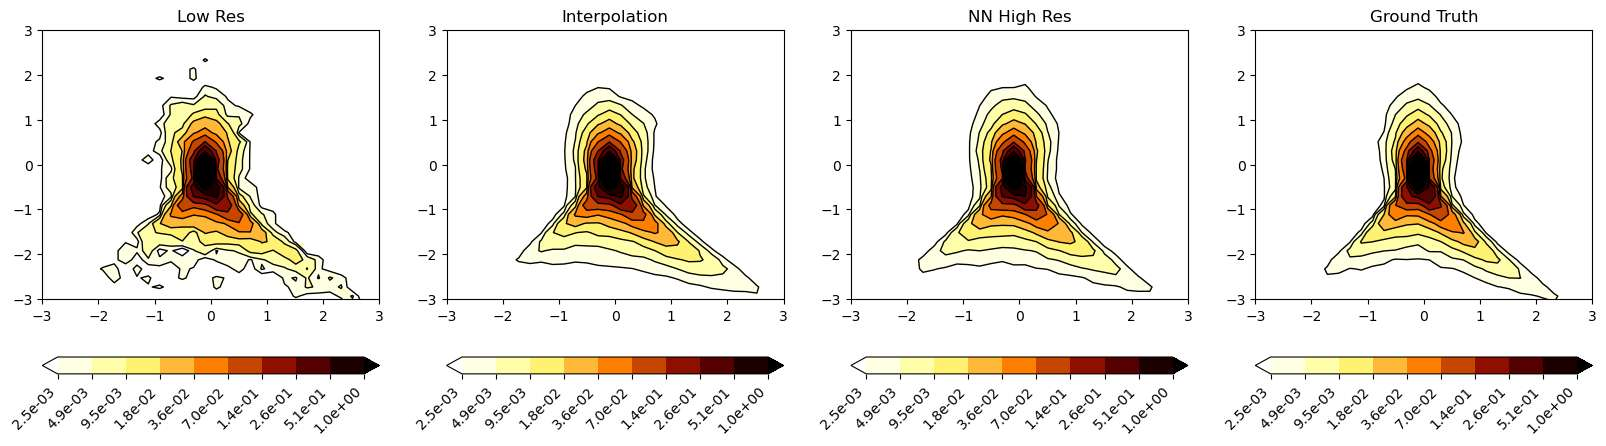

In [5]:
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LogNorm

# compute 2d histograms
# average the signals before histograms
H_lr_true_list, xedges_lr_true_list, yedges_lr_true_list = [], [], []
H_hr_interp_list, xedges_hr_interp_list, yedges_hr_interp_list = [], [], []
H_hr_true_list, xedges_hr_true_list, yedges_hr_true_list = [], [], []
H_hr_pred_list, xedges_hr_pred_list, yedges_hr_pred_list = [], [], []
Redges0 = np.linspace(-10.0, 10.0, num=100)
Qedges0 = np.linspace(-10.0, 10.0, num=100)

bins = (Redges0, Qedges0)
# average over all samples if required
for i in range(1):
    H_lr_true, xedges_lr_true, yedges_lr_true = np.histogram2d(
        r_lr_true[0].cpu().numpy().flatten(),
        q_lr_true[0].cpu().numpy().flatten(),
        bins=bins,
        density=True,
    )
    H_lr_true_list.append(H_lr_true)
    xedges_lr_true_list.append(xedges_lr_true)
    yedges_lr_true_list.append(yedges_lr_true)

    H_hr_interp, xedges_hr_interp, yedges_hr_interp = np.histogram2d(
        r_hr_interp[0].cpu().numpy().flatten(),
        q_hr_interp[0].cpu().numpy().flatten(),
        bins=bins,
        density=True,
    )
    H_hr_interp_list.append(H_hr_interp)
    xedges_hr_interp_list.append(xedges_hr_interp)
    yedges_hr_interp_list.append(yedges_hr_interp)

    H_hr_true, xedges_hr_true, yedges_hr_true = np.histogram2d(
        r_hr_true[0].cpu().numpy().flatten(),
        q_hr_true[0].cpu().numpy().flatten(),
        bins=bins,
        density=True,
    )
    H_hr_true_list.append(H_hr_true)
    xedges_hr_true_list.append(xedges_hr_true)
    yedges_hr_true_list.append(yedges_hr_true)

    H_hr_pred, xedges_hr_pred, yedges_hr_pred = np.histogram2d(
        r_hr_pred[0].cpu().numpy().flatten(),
        q_hr_pred[0].cpu().numpy().flatten(),
        bins=bins,
        density=True,
    )
    H_hr_pred_list.append(H_hr_pred)
    xedges_hr_pred_list.append(xedges_hr_pred)
    yedges_hr_pred_list.append(yedges_hr_pred)

H_lr_true, xedges_lr_true, yedges_lr_true = (
    np.mean(np.stack(H_lr_true_list), axis=0),
    np.mean(np.stack(xedges_lr_true_list), axis=0),
    np.mean(np.stack(yedges_lr_true_list), axis=0),
)
H_hr_interp, xedges_hr_interp, yedges_hr_interp = (
    np.mean(np.stack(H_hr_interp_list), axis=0),
    np.mean(np.stack(xedges_hr_interp_list), axis=0),
    np.mean(np.stack(yedges_hr_interp_list), axis=0),
)
H_hr_true, xedges_hr_true, yedges_hr_true = (
    np.mean(np.stack(H_hr_true_list), axis=0),
    np.mean(np.stack(xedges_hr_true_list), axis=0),
    np.mean(np.stack(yedges_hr_true_list), axis=0),
)
H_hr_pred, xedges_hr_pred, yedges_hr_pred = (
    np.mean(np.stack(H_hr_pred_list), axis=0),
    np.mean(np.stack(xedges_hr_pred_list), axis=0),
    np.mean(np.stack(yedges_hr_pred_list), axis=0),
)

x_lr_true, y_lr_true = np.meshgrid(xedges_lr_true[:-1], yedges_lr_true[:-1])
x_hr_interp, y_hr_interp = np.meshgrid(xedges_hr_interp[:-1], yedges_hr_interp[:-1])
x_hr_true, y_hr_true = np.meshgrid(xedges_hr_true[:-1], yedges_hr_true[:-1])
x_hr_pred, y_hr_pred = np.meshgrid(xedges_hr_pred[:-1], yedges_hr_pred[:-1])


contour_levels = np.geomspace(2.5e-03, 1, num=10)
# contour_levels = np.linspace(2.5e-03, 10e-02, num=10)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
da = axs[0].contour(
    x_lr_true,
    y_lr_true,
    H_lr_true.T,
    levels=contour_levels,
    colors="k",
    origin="lower",
    extend="both",
    linewidths=1,
)
da = axs[0].contourf(
    x_lr_true,
    y_lr_true,
    H_lr_true.T,
    levels=contour_levels,
    cmap="afmhot_r",
    origin="lower",
    extend="both",
    locator=ticker.LogLocator(),
    norm=LogNorm(),
)
cb = fig.colorbar(da, ax=axs[0], orientation="horizontal", format="%.1e")
cb.set_ticks(contour_levels)
cb.update_ticks()
cb.ax.set_xticklabels(cb.ax.get_xticklabels(), rotation=45, ha="right")

axs[0].set_title("Low Res")
axs[0].set_xlim([-3, 3])
axs[0].set_ylim([-3, 3])

da = axs[1].contour(
    x_hr_interp,
    y_hr_interp,
    H_hr_interp.T,
    levels=contour_levels,
    colors="k",
    origin="lower",
    extend="both",
    linewidths=1,
)
da = axs[1].contourf(
    x_hr_interp,
    y_hr_interp,
    H_hr_interp.T,
    levels=contour_levels,
    cmap="afmhot_r",
    origin="lower",
    extend="both",
    locator=ticker.LogLocator(),
    norm=LogNorm(),
)
cb = fig.colorbar(da, ax=axs[1], orientation="horizontal", format="%.1e")
cb.set_ticks(contour_levels)
cb.update_ticks()
cb.ax.set_xticklabels(cb.ax.get_xticklabels(), rotation=45, ha="right")

axs[1].set_title("Interpolation")
axs[1].set_xlim([-3, 3])
axs[1].set_ylim([-3, 3])

da = axs[2].contour(
    x_hr_pred,
    y_hr_pred,
    H_hr_pred.T,
    levels=contour_levels,
    colors="k",
    origin="lower",
    extend="both",
    linewidths=1,
)
da = axs[2].contourf(
    x_hr_pred,
    y_hr_pred,
    H_hr_pred.T,
    levels=contour_levels,
    cmap="afmhot_r",
    origin="lower",
    extend="both",
    locator=ticker.LogLocator(),
    norm=LogNorm(),
)
cb = fig.colorbar(da, ax=axs[2], orientation="horizontal", format="%.1e")
cb.set_ticks(contour_levels)
cb.update_ticks()
cb.ax.set_xticklabels(cb.ax.get_xticklabels(), rotation=45, ha="right")

axs[2].set_title("NN High Res")
axs[2].set_xlim([-3, 3])
axs[2].set_ylim([-3, 3])

da = axs[3].contour(
    x_hr_true,
    y_hr_true,
    H_hr_true.T,
    levels=contour_levels,
    colors="k",
    origin="lower",
    extend="both",
    linewidths=1,
)
da = axs[3].contourf(
    x_hr_true,
    y_hr_true,
    H_hr_true.T,
    levels=contour_levels,
    cmap="afmhot_r",
    origin="lower",
    extend="both",
    locator=ticker.LogLocator(),
    norm=LogNorm(),
)
cb = fig.colorbar(da, ax=axs[3], orientation="horizontal", format="%.1e")
cb.set_ticks(contour_levels)
cb.update_ticks()
cb.ax.set_xticklabels(cb.ax.get_xticklabels(), rotation=45, ha="right")

axs[3].set_title("Ground Truth")
axs[3].set_xlim([-3, 3])
axs[3].set_ylim([-3, 3])

plt.show()

It can be observed that the NN prediction is able to replicate the overall shape of the Q-R plot of the Ground truth. The interpolated signal does much poor job in replicating the shape of the QR plot with even lesser finer level structures.

## Compute continuity errors

In this section we will compute the continuity residuals in differential and integral sense.

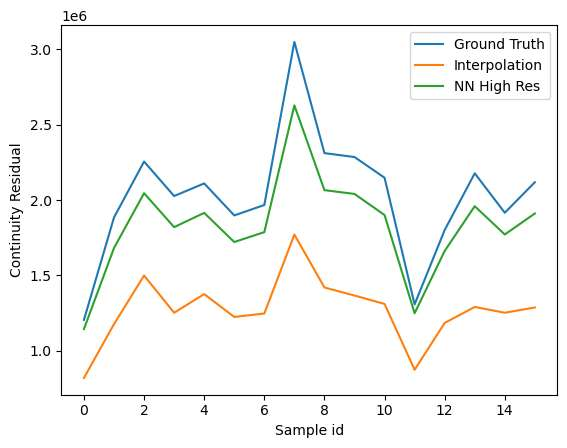

In [6]:
import matplotlib.pyplot as plt
from inference_utils import compute_continuity

true_continuity = compute_continuity(U_hr_true)
interp_continuity = compute_continuity(U_hr_interp)
pred_continuity = compute_continuity(U_hr_pred)

plt.plot(
    torch.sum(torch.abs(true_continuity), dim=(1, 2, 3, 4)).cpu().numpy(),
    label="Ground Truth",
)
plt.plot(
    torch.sum(torch.abs(interp_continuity), dim=(1, 2, 3, 4)).cpu().numpy(),
    label="Interpolation",
)
plt.plot(
    torch.sum(torch.abs(pred_continuity), dim=(1, 2, 3, 4)).cpu().numpy(),
    label="NN High Res",
)
plt.ylabel("Continuity Residual")
plt.xlabel("Sample id")
plt.legend()
plt.show()

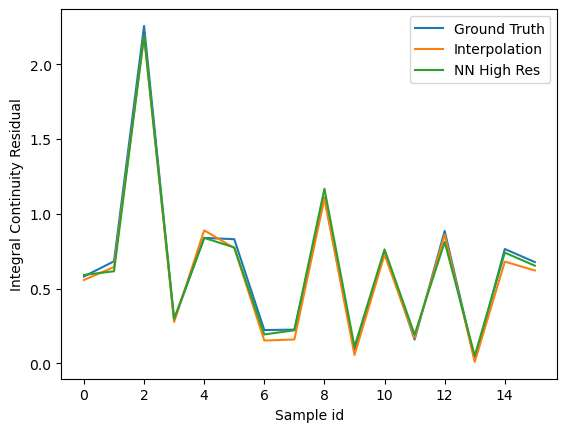

In [7]:
# Compute integral continuity
# computing outflow - inflow across the batch dimension

true_integral_continuity = (
    torch.mean(U_hr_true[:, 0, -1, :, :], dim=(-2, -1))
    - torch.mean(U_hr_true[:, 0, 0, :, :], dim=(-2, -1))
    + torch.mean(U_hr_true[:, 1, :, -1, :], dim=(-2, -1))
    - torch.mean(U_hr_true[:, 1, :, 0, :], dim=(-2, -1))
    + torch.mean(U_hr_true[:, 2, :, :, -1], dim=(-2, -1))
    - torch.mean(U_hr_true[:, 2, :, :, 0], dim=(-2, -1))
)

interp_integral_continuity = (
    torch.mean(U_hr_interp[:, 0, -1, :, :], dim=(-2, -1))
    - torch.mean(U_hr_interp[:, 0, 0, :, :], dim=(-2, -1))
    + torch.mean(U_hr_interp[:, 1, :, -1, :], dim=(-2, -1))
    - torch.mean(U_hr_interp[:, 1, :, 0, :], dim=(-2, -1))
    + torch.mean(U_hr_interp[:, 2, :, :, -1], dim=(-2, -1))
    - torch.mean(U_hr_interp[:, 2, :, :, 0], dim=(-2, -1))
)

pred_integral_continuity = (
    torch.mean(U_hr_pred[:, 0, -1, :, :], dim=(-2, -1))
    - torch.mean(U_hr_pred[:, 0, 0, :, :], dim=(-2, -1))
    + torch.mean(U_hr_pred[:, 1, :, -1, :], dim=(-2, -1))
    - torch.mean(U_hr_pred[:, 1, :, 0, :], dim=(-2, -1))
    + torch.mean(U_hr_pred[:, 2, :, :, -1], dim=(-2, -1))
    - torch.mean(U_hr_pred[:, 2, :, :, 0], dim=(-2, -1))
)

plt.plot(torch.abs(true_integral_continuity).cpu().numpy(), label="Ground Truth")
plt.plot(torch.abs(interp_integral_continuity).cpu().numpy(), label="Interpolation")
plt.plot(torch.abs(pred_integral_continuity).cpu().numpy(), label="NN High Res")
plt.ylabel("Integral Continuity Residual")
plt.xlabel("Sample id")
plt.legend()
plt.show()

The signals with higher resolution show more errors on continuity residual. This can be attributed to the smoothness of the signal which results in effectively lower values of the velocity gradients. In an integral sense, the differences are much less visible. 

Another way to visualize the continutity errors is by plotting the histogram of the `P` (first invariant of velocity gradient tensor). For incompressible flows, the `P` should be zero. 

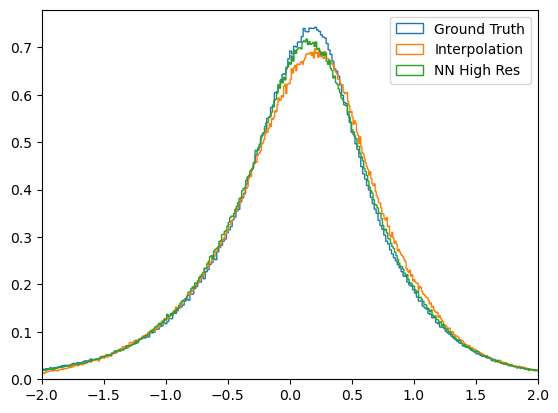

In [8]:
n_hr, x_hr, _ = plt.hist(
    p_hr_true[0].cpu().numpy(),
    bins=1000,
    density=True,
    histtype="step",
    label="Ground Truth",
)
n_interp, x_interp, _ = plt.hist(
    p_hr_interp[0].cpu().numpy(),
    bins=1000,
    density=True,
    histtype="step",
    label="Interpolation",
)
n_pred, x_pred, _ = plt.hist(
    p_hr_pred[0].cpu().numpy(),
    bins=1000,
    density=True,
    histtype="step",
    label="NN High Res",
)

plt.xlim([-2, 2])

plt.legend()

From the histogram plot, it is evident that the Ground truth signal shows better agreement, followed by the Neural Network super-resolution and then followed by interpolation. The ground truth signal should ideally have peak distribution at zero for `P`, and from the plot it can be seen that this is not the case. This can be attributed to the truncation errors (true data was computed in FP64) and also from the differences in gradient computed schemes - the original simulation data prepared by JHTDB uses a pseudo-spectral solver on a periodic domain. For this evaluation, due to the non-periodic slices, we use finite difference, but it can be easily replaced with any other gradient computing schemes. 

## Compute the energy spectrum

An important aspect of analysis of turbulent flow is the analysis of its turbulent kinetic energy spectrum. In the next section, we will do the spectral analysis for the interpolation and the neural network result and see how they compare with the high resolution results


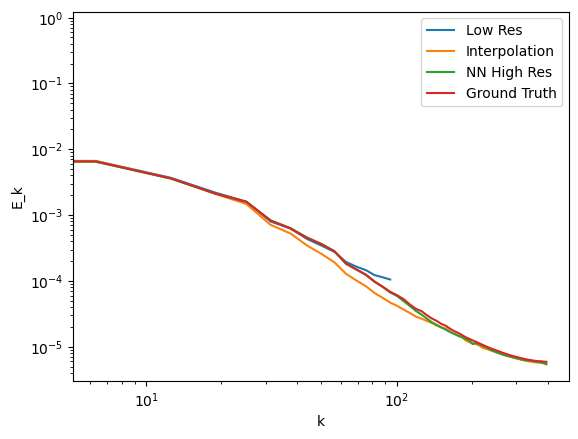

In [9]:
import matplotlib.pyplot as plt
from inference_utils import compute_tke_spectrum

true_lr_wave_numbers, true_lr_tke_spectrum = [], []
interp_hr_wave_numbers, interp_hr_tke_spectrum = [], []
true_hr_wave_numbers, true_hr_tke_spectrum = [], []
pred_hr_wave_numbers, pred_hr_tke_spectrum = [], []

# Average over all samples if required
for i in range(1):  # range(U_lr_true.shape[0]):
    _, _, wv, e = compute_tke_spectrum(U_lr_true[i].cpu().numpy())
    true_lr_wave_numbers.append(wv), true_lr_tke_spectrum.append(e)
    _, _, wv, e = compute_tke_spectrum(U_hr_interp[i].cpu().numpy())
    interp_hr_wave_numbers.append(wv), interp_hr_tke_spectrum.append(e)
    _, _, wv, e = compute_tke_spectrum(U_hr_true[i].cpu().numpy())
    true_hr_wave_numbers.append(wv), true_hr_tke_spectrum.append(e)
    _, _, wv, e = compute_tke_spectrum(U_hr_pred[i].cpu().numpy())
    pred_hr_wave_numbers.append(wv), pred_hr_tke_spectrum.append(e)

true_lr_wave_numbers, true_lr_tke_spectrum = (
    np.stack(true_lr_wave_numbers, axis=0).mean(axis=0),
    np.stack(true_lr_tke_spectrum, axis=0).mean(axis=0),
)
interp_hr_wave_numbers, interp_hr_tke_spectrum = (
    np.stack(interp_hr_wave_numbers, axis=0).mean(axis=0),
    np.stack(interp_hr_tke_spectrum, axis=0).mean(axis=0),
)
true_hr_wave_numbers, true_hr_tke_spectrum = (
    np.stack(true_hr_wave_numbers, axis=0).mean(axis=0),
    np.stack(true_hr_tke_spectrum, axis=0).mean(axis=0),
)
pred_hr_wave_numbers, pred_hr_tke_spectrum = (
    np.stack(pred_hr_wave_numbers, axis=0).mean(axis=0),
    np.stack(pred_hr_tke_spectrum, axis=0).mean(axis=0),
)

filter_lr = true_lr_wave_numbers < (16 * 2 * np.pi)
filter = true_hr_wave_numbers < (64 * 2 * np.pi)
plt.plot(
    true_lr_wave_numbers[filter_lr], true_lr_tke_spectrum[filter_lr], label="Low Res"
)
plt.plot(
    interp_hr_wave_numbers[filter],
    interp_hr_tke_spectrum[filter],
    label="Interpolation",
)
plt.plot(
    pred_hr_wave_numbers[filter], pred_hr_tke_spectrum[filter], label="NN High Res"
)
plt.plot(
    true_hr_wave_numbers[filter], true_hr_tke_spectrum[filter], label="Ground Truth"
)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("E_k")
plt.xlabel("k")
plt.legend()
plt.show()

From the spectrum plots again it can be observed that the Neural Network result performs better than the trilinear interpolation and matches better with the Ground truth. The spectrums start deviating at the higher wave numbers suggesting lower details being captured by the Low res and the interpolation technique compared to the NN method. 